# OFFLINE PATH PLANNING OPTIMISATION
This notebook elaborates the testing and development of an offline path planning optimisation pipeline to generate a safe and feasible reference path for a ego vehicle. The pipeline takes a set of coarsely placed waypoints and adjusts their localisation so as to comply with certain **path curvature** constraints in view of the vehicle's size and steering capability. The adjusted waypoints should be as close as possible to the original waypoints without violating the curvature constraints.

## Setup
Due to the way Python and Windows handle concurrency, it is less efficient to run this notebook on a Windows operating system.

### Installation
Before beginning, it is important to install all the dependencies to run all cells in this notebook. You can do that by running the following cell after converting the Markdown into code.

!pip install -r requirements.txt

### Imports

In [2]:
import os
import time as t
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.optimize import minimize

### Importing the Generated Waypoints

In [3]:
dir_path = 'ngeeann.csv'
df = pd.read_csv(dir_path)
wx = df['x'].values.tolist()
wy = df['y'].values.tolist()

if len(wx) != len(wy):
    raise Exception("Waypoints are not valid. Length of axes do not match.")

else:
    wn = len(wx)
    print("Number of generated waypoints: {}".format(wn))

Number of generated waypoints: 117


### Constructing the Seeding Path
According to the authors, if the seeding path is curvature-discontinous, the algorithm would take longer to converge. They suggest performing cubic interpolation to generate the seeding path. Since the road geometry and the seeding path is the same, the seeding path $P^{\text{seed}}$ can be expressed as a set of $N$ points, sampled at $\Delta{s}$ intervals. This is written as,
$$
P^{\text{seed}} = \{P^{\text{seed}}_i \ | \ i = 0 \ ...\ N-1 \}.
$$

In [4]:
from bisect import bisect

class Spline:

    def __init__(self, x, y):
        
        self.x = x
        self.y = y

        self.a = y
        self.b = []
        self.d = []

        dim_size = max(len(x), len(y))
        h = np.diff(x)

        A = self.matrixA(h, dim_size)
        B = self.matrixB(h, dim_size)
        self.c = np.linalg.solve(A, B)

        for i in range(dim_size - 1):
            self.b.append((self.a[i + 1] - self.a[i])/h[i] - h[i]*(self.c[i + 1] + 2.0*self.c[i]) / 3.0)
            self.d.append((self.c[i + 1] - self.c[i]) / (3.0 * h[i]))

    def matrixA(self, h, size):
        
        A = np.zeros((size, size))
        A[0, 0] = 1.0

        for i in range(size - 1):
            if i != (size - 2):
                A[i + 1, i + 1] = 2.0 * (h[i] + h[i + 1])

            A[i + 1, i] = h[i]
            A[i, i + 1] = h[i]

        A[0, 1] = 0.0
        A[size - 1, size - 2] = 0.0
        A[size - 1, size - 1] = 1.0

        return A

    def matrixB(self, h, size):
        
        B = np.zeros(size)

        for i in range(size - 2):
            B[i + 1] = 3.0 * (self.a[i + 2] - self.a[i + 1]) / h[i + 1] - 3.0 * (self.a[i + 1] - self.a[i]) / h[i]
            
        return B

    def solve_function(self, x):
        
        if x < self.x[0]:
            return None

        elif x > self.x[-1]:
            return None

        else:
            i = self.search_index(x)
            deltax = x - self.x[i]
            result = self.a[i] + self.b[i]*deltax + self.c[i]*deltax**2.0 + self.d[i]*deltax**3.0

            return result

    def solve_1st_derivative(self, x):
        
        if x < self.x[0]:
            return None

        elif x > self.x[-1]:
            return None

        else:
            i = self.search_index(x)
            deltax = x - self.x[i]
            result = self.b[i] + 2.0*self.c[i]*deltax + 3.0*self.d[i]*deltax**2.0

            return result

    def solve_2nd_derivative(self, x):
        
        if x < self.x[0]:
            return None

        elif x > self.x[-1]:
            return None

        else:
            i = self.search_index(x)
            deltax = x - self.x[i]
            result = 2.0*self.c[i] + 6.0*self.d[i] * deltax

            return result

    def search_index(self, x):

        i = bisect(self.x, x) - 1

        return i

class Spline2D:

    def __init__(self, x, y):

        self.ds = None

        self.s = self.calculate_s(x, y)
        self.sx = Spline(self.s, x)
        self.sy = Spline(self.s, y)

    def calculate_s(self, x, y):
        
        deltax = np.diff(x)
        deltay = np.diff(y)
        self.ds = np.hypot(deltax, deltay)

        s = [0]
        s.extend(np.cumsum(self.ds))

        return s

    def calculate_position(self, s):
        
        x = self.sx.solve_function(s)
        y = self.sy.solve_function(s)

        return x, y

    def calculate_yaw(self, s):
        
        dx = self.sx.solve_1st_derivative(s)
        dy = self.sy.solve_1st_derivative(s)
        yaw = np.arctan2(dy, dx)

        return yaw

    def calculate_curvature(self, s):
        
        dx = self.sx.solve_1st_derivative(s)
        ddx = self.sx.solve_2nd_derivative(s)
        dy = self.sy.solve_1st_derivative(s)
        ddy = self.sy.solve_2nd_derivative(s)

        k = (ddy*dx - ddx*dy) / ((dx**2 + dy**2)**(3 / 2))

        return k

def generate_cubic_path(x, y, ds=0.05):

    sp2d = Spline2D(x, y)
    s = np.arange(0, sp2d.s[-1], ds)

    px = []
    py = []
    pyaw = []
    pk = []

    for i in s:
        ix, iy = sp2d.calculate_position(i)
        px.append(ix)
        py.append(iy)
        pyaw.append(sp2d.calculate_yaw(i))
        pk.append(sp2d.calculate_curvature(i))

    return px, py, pyaw, pk

ds = 1.0
%time px, py, pyaw, pk = generate_cubic_path(wx, wy, ds)
cum_pk = np.mean(np.absolute(pk))

print("Number of points in the seeding path: {}".format(len(pk)))
print("Linear distance between each point: {} m".format(ds))

Wall time: 21.9 ms
Number of points in the seeding path: 665
Linear distance between each point: 1.0 m


### Calculate Curvature
We will need to calculate the yaw of each waypoints so that we can set our road boundaries later. The solution can be found [here](https://www.math24.net/curvature-radius).

In [5]:
def solve_1st_derivative(x, y):

    dx = []
    dy = []

    for i in range(0, max(len(x), len(y)) - 1):
        dx.append(x[i+1] - x[i])
        dy.append(y[i+1] - y[i])

    dx.append(dx[-1])
    dy.append(dy[-1])

    return dx, dy

def calculate_curvature(x, y):

    dx, dy = solve_1st_derivative(x, y)
    ddx, ddy = solve_1st_derivative(dx, dy)

    k = []
    
    for i in range(0, max(len(x), len(y))):
        k.append((ddy[i]*dx[i] - ddx[i]*dy[i]) / ((dx[i]*dx[i] + dy[i]*dy[i])**(3/2)))

    return k
    
def calculate_curvature_vector(x, y):

    delta_s = []
    u_i = []
    k_i = []

    for i in range(0, max(len(x), len(y)) - 1):
        p_current = np.array([x[i], y[i]])
        p_next = np.array([x[i + 1], y[i + 1]])
        dp = p_next - p_current

        delta_s.append(np.hypot(dp[0], dp[1]))
        u_i.append(dp / delta_s[i])

    delta_s.append(delta_s[-1])
    u_i.append(u_i[-1])

    for i in range(0, max(len(x), len(y)) - 1):
        du = u_i[i + 1] - u_i[i]
        abs_du = np.hypot(du[0], du[1])
        k_i.append(abs_du/delta_s[i])

    k_i.append(k_i[-1])

    return k_i

# def calculate_shortest_distance(x, y):

#     dx = np.absolute(solve_1st_derivative(np.zeros(len(x)), x))
#     dy = np.absolute(solve_1st_derivative(np.zeros(len(y)), y))
#     ddist = np.hypot(dx, dy)

#     return np.sum(ddist)

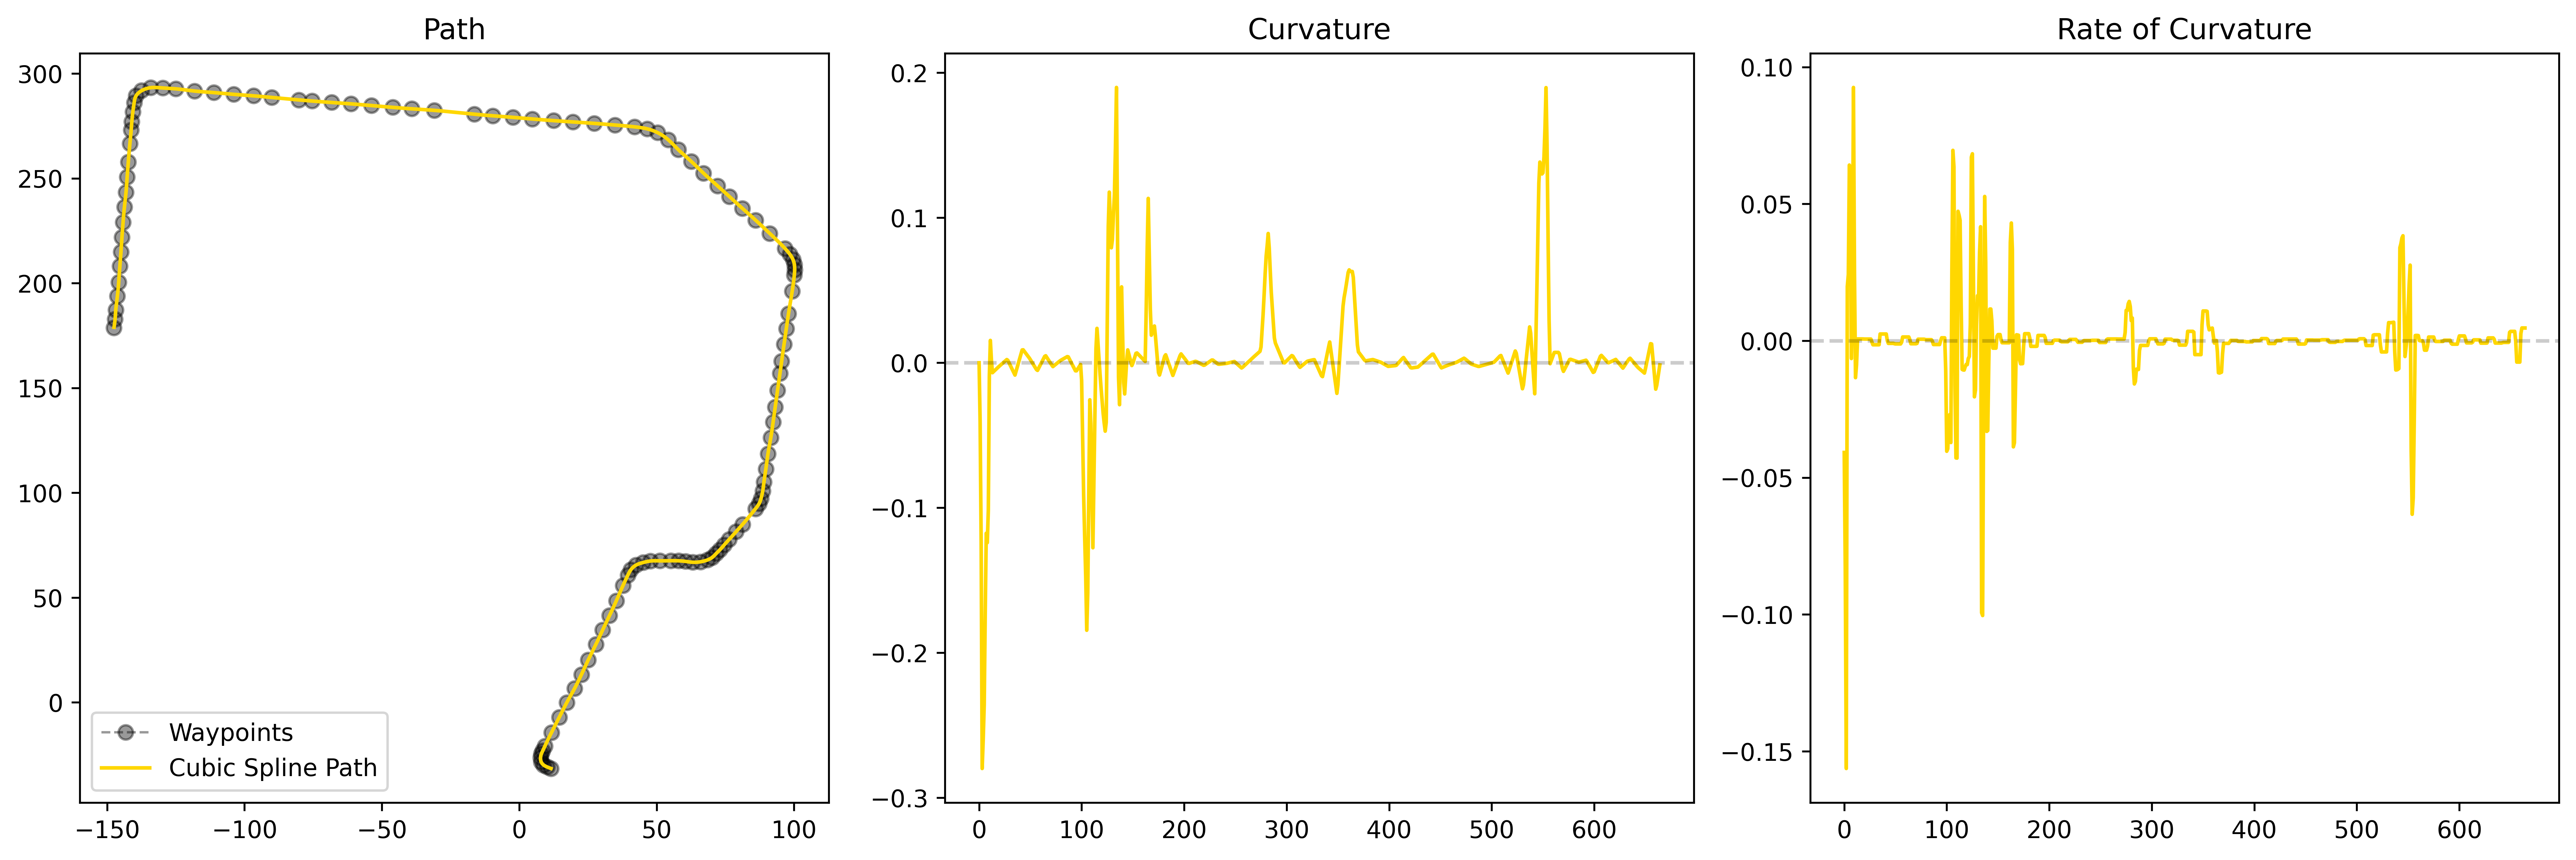

In [6]:
%matplotlib inline

dpk, _ = solve_1st_derivative(pk, pk)

fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=600)

ax[0].set_box_aspect(1)
ax[0].set_title('Path')
ax[0].plot(wx, wy, '--ok', linewidth=1, alpha=0.4, label='Waypoints')
ax[0].plot(px, py, color='gold', label='Cubic Spline Path')
ax[0].legend()

ax[1].set_box_aspect(1)
ax[1].set_title('Curvature')
ax[1].plot(pk, color='gold')
ax[1].axhline(0, linestyle='--', color='k', alpha=0.2)

ax[2].set_box_aspect(1)
ax[2].set_title('Rate of Curvature')
ax[2].plot(dpk, color='gold')
ax[2].axhline(0, linestyle='--', color='k', alpha=0.2)

plt.tight_layout()
plt.show()

### Split Seeding Paths
To increase computation efficacy during optimisation, the path should be split into smaller arrays.

In [7]:
px_split = [px[x:x + 50] for x in range(0, len(px), 50)]
py_split = [py[y:y + 50] for y in range(0, len(py), 50)]
pyaw_split = [pyaw[yaw:yaw + 50] for yaw in range(0, len(pyaw), 50)]

print("No. of splitted paths: {}".format(len(pyaw_split)))

No. of splitted paths: 14


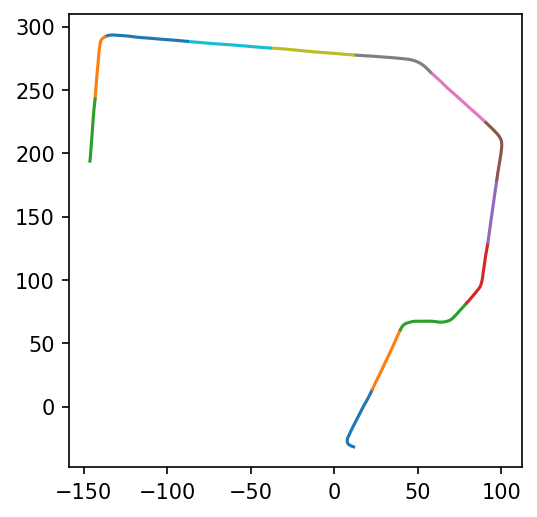

In [8]:
%matplotlib inline

plt.figure(dpi=150)
plt.axes().set_box_aspect(1)

for i in range(0, len(px_split) - 1):
    plt.plot(px_split[i], py_split[i])

plt.show()

## Approach 2: Focused Trajectory Planning for Autonomous On-Road Driving (Modified)

### Define the boundary
For path planning, the boundary given are the bounds of optimisation. They can be represented as,
$$
o_i + o_i^{\text{seed}} \in [r_i, \ l_i],
$$
where $o_i$ is the lateral offset from the seeding path, $o_i^{\text{seed}}$ is the lateral offset from the centre of the road, and the value pairs of $l_i$ and $r_i$ are the left and right road boundaries, respectively. Of course, since the seeding path is the middle of the road, the value of $o_i^{\text{seed}}$ is zero and can be ignored in our equations. Thus, we can rewrite the equation as,
$$
o_i \in [r_i, \ l_i].
$$

In [93]:
road_lx = []
road_ly = []
road_rx = []
road_ry = []
lx = []
ly = []
rx = []
ry = []
road_lx_split = []
road_ly_split = []
road_rx_split = []
road_ry_split = []
lx_split = []
ly_split = []
rx_split = []
ry_split = []
bound = []
bounds = []

road_offset = 3
max_lateral_offset = road_offset - 2.5


for n in range(0, len(pyaw_split)):
    for i in range(0, len(pyaw_split[n])):
        road_lx.append(px_split[n][i] - road_offset*np.sin(pyaw_split[n][i]))
        road_ly.append(py_split[n][i] + road_offset*np.cos(pyaw_split[n][i]))
        road_rx.append(px_split[n][i] + road_offset*np.sin(pyaw_split[n][i]))
        road_ry.append(py_split[n][i] - road_offset*np.cos(pyaw_split[n][i]))

    road_lx_split.append(road_lx)
    road_ly_split.append(road_ly)
    road_rx_split.append(road_rx)
    road_ry_split.append(road_ry)
    road_lx = []
    road_ly = []
    road_rx = []
    road_ry = []

    for i in range(0, len(pyaw_split[n])):
        lx.append(px_split[n][i] - max_lateral_offset*np.sin(pyaw_split[n][i]))
        ly.append(py_split[n][i] + max_lateral_offset*np.cos(pyaw_split[n][i]))
        rx.append(px_split[n][i] + max_lateral_offset*np.sin(pyaw_split[n][i]))
        ry.append(py_split[n][i] - max_lateral_offset*np.cos(pyaw_split[n][i]))

    lx_split.append(lx)
    ly_split.append(ly)
    rx_split.append(rx)
    ry_split.append(ry)
    lx = []
    ly = []
    rx = []
    ry = []

    for b in range(0, len(pyaw_split[n])):
        if b == 0 or b == len(pyaw_split[n]):
            bound.append((-0.0001, 0.0001))

        else:
            bound.append((-max_lateral_offset, max_lateral_offset))

    # for b in range(0, len(pyaw_split[n])):
    #     bound.append((-max_lateral_offset, max_lateral_offset))

    bounds.append(tuple(bound))
    bound = []

print("Length of bounds: {}".format(len(bounds)))

Length of bounds: 14


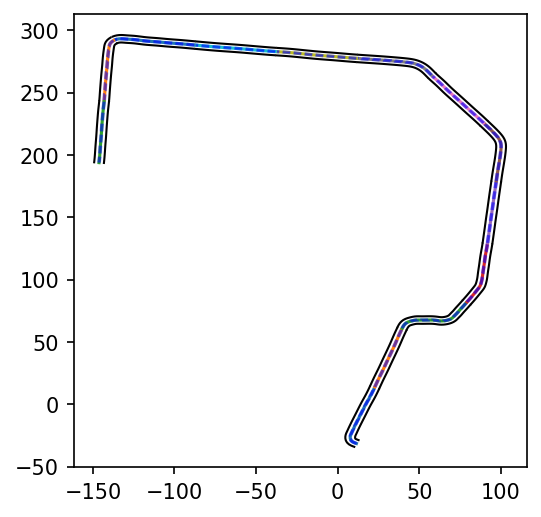

In [94]:
%matplotlib inline

plt.figure(dpi=150)
plt.axes().set_box_aspect(1)

for i in range(0, len(px_split) - 1):
    plt.plot(px_split[i], py_split[i])
    plt.plot(road_lx_split[i], road_ly_split[i], '-k', linewidth=1)
    plt.plot(road_rx_split[i], road_ry_split[i], '-k', linewidth=1)
    plt.plot(lx_split[i], ly_split[i], '--b', alpha=0.5, linewidth=1)
    plt.plot(rx_split[i], ry_split[i], '--b', alpha=0.5, linewidth=1)

plt.show()

plt.show()

### Define the Objective Function
For the objective function, we will slightly modify the previous optimisation criterion, but this time we will let the path curvature be a quadratic function. Hence, the optimisation criterion is rewritten as,
$$
\min(\sum^{N-1}_{i=0}{w_k \cdot |k_i^2| + (1 - w_k) \cdot |o_i|}).
$$

In [95]:
def objective_fcn_mod(lateral_offset, segment):

    wk = 0.997
    mox = px_split[segment].copy()
    moy = py_split[segment].copy()

    for n in range(0, len(pyaw_split[segment])):
        mox[n] -= lateral_offset[n]*np.sin(pyaw_split[segment][n])
        moy[n] += lateral_offset[n]*np.cos(pyaw_split[segment][n])

    mok = calculate_curvature_vector(mox, moy)

    # Curvature cost
    curvature_cost = wk * np.mean(np.square(mok))

    # Offset cost
    offset_cost = (1 - wk) * np.mean(np.absolute(lateral_offset))

    return curvature_cost + curvature_cost

### Define the Initial Values

In [96]:
guesses = []
for i in range(0, len(pyaw_split)):
    guesses.append(np.zeros(len(pyaw_split[i])))
    
print("Length of each guess: {}".format(len(guesses[0])))
print("Cost: {}".format(objective_fcn_mod(guesses[0], 0)))

Length of each guess: 50
Cost: 0.011082848516222231


### Define the Constraints
We can represent our constraint on curvature as the following inequality,
$$
||k_i|| \leq k_{\text{max}},
$$
where $k_{\text{max}}$ is the maximum curvature allowed. For compatibility with SciPy's `minimize()` function, the former equation must be rewritten as,
$$
k_{\text{max}} - ||k_i|| \geq 0
$$
Likewise, the constraint on rate of curvature can be written as,
$$
k'_{\text{max}} - ||k_i'|| \geq 0.
$$

In [97]:
kmax = 0.3
kmax_rate = 0.1

def max_curvature_rate_constraint(lateral_offset, segment):

    mox = px_split[segment].copy()
    moy = py_split[segment].copy()

   # Curvature cost
    for n in range(0, len(pyaw_split[segment])):
        mox[n] -= lateral_offset[n]*np.sin(pyaw_split[segment][n])
        moy[n] += lateral_offset[n]*np.cos(pyaw_split[segment][n])

    mok = calculate_curvature_vector(mox, moy)
    dmok, _ = solve_1st_derivative(mok, mok)
    abs_dk = np.absolute(dmok)
    dk_i = np.max(abs_dk)

    return kmax_rate - dk_i

def max_curvature_constraint(lateral_offset, segment):

    mox = px_split[segment].copy()
    moy = py_split[segment].copy()

   # Curvature cost
    for n in range(0, len(pyaw_split[segment])):
        mox[n] -= lateral_offset[n]*np.sin(pyaw_split[segment][n])
        moy[n] += lateral_offset[n]*np.cos(pyaw_split[segment][n])

    mok = calculate_curvature_vector(mox, moy)
    k_i = np.max(mok)

    return kmax - k_i

### Optimise
> WARNING: If speed is of importance, `visualise` should be set to `False`, as the animation will massively slow down optimisation performance.
>

In [98]:
visualise = False

print("REMINDER: Parallel optimisation is not possible. Optimising..")

start = t.time()

if visualise:

    from IPython.display import display, clear_output
    fig_cb = plt.figure(dpi=150)
    Nfeval = 0

    def callback(Xi, segment):

        global Nfeval

        mox = px_split[segment].copy()
        moy = py_split[segment].copy()

        for n in range(0, len(pyaw_split[segment])):
            mox[n] -= Xi[n]*np.sin(pyaw_split[segment][n])
            moy[n] += Xi[n]*np.cos(pyaw_split[segment][n])

        mok = calculate_curvature(mox, moy)
        cum_mok = np.mean(np.absolute(mok))

        plt.clf()
        plt.axes().set_box_aspect(1)
        plt.plot(lx_split[segment], ly_split[segment], '--b', alpha=0.5, linewidth=1)
        plt.plot(rx_split[segment], ry_split[segment], '--b', alpha=0.5, linewidth=1)
        plt.plot(road_lx_split[segment], road_ly_split[segment], '-k', linewidth=1)
        plt.plot(road_rx_split[segment], road_ry_split[segment], '-k', linewidth=1)
        plt.plot(px_split[segment], py_split[segment], '--', color='gold', linewidth=1)
        plt.plot(mox, moy, '-', color='magenta')
        plt.title("{} iterations".format(Nfeval), loc='right')
        plt.xlabel("Cumulative Curvature: {}".format(np.around(cum_mok, 4)))

        # plt.savefig('fig/visualisation_{0:03}.png'.format(Nfeval), dpi=150)

        Nfeval += 1
        clear_output(wait=True)
        display(fig_cb)

    %time result = minimize(objective_fcn_mod, guess, arguments, bounds=bounds, constraints=constraints, options={'maxiter': 1000000}, callback=callback)

else:
    result = list(range(0, len(pyaw_split)))
    for iters in range(0, len(pyaw_split)):
        arguments = (iters,)
        max_curavture_rate = {'type': 'ineq', 'fun': max_curvature_rate_constraint, 'args': arguments}
        max_curvature = {'type': 'ineq', 'fun': max_curvature_constraint, 'args': arguments}
        constraints = [max_curvature, max_curavture_rate]
        %time result[iters] = minimize(objective_fcn_mod, guesses[iters], arguments, bounds=bounds[iters], options={'maxiter': 1000000})

end = t.time()
modified_time = end - start
print("Message: {}".format(result[iters].message))
print("Success: {}".format(result[iters].success))

REMINDER: Parallel optimisation is not possible. Optimising..
Wall time: 8.44 s
Wall time: 2.05 s
Wall time: 3.19 s
Wall time: 8.17 s
Wall time: 1.98 s
Wall time: 2 s
Wall time: 3.01 s
Wall time: 5.39 s
Wall time: 3.67 s
Wall time: 2.94 s
Wall time: 8.4 s
Wall time: 8.22 s
Wall time: 5.16 s
Wall time: 125 ms
Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Success: True


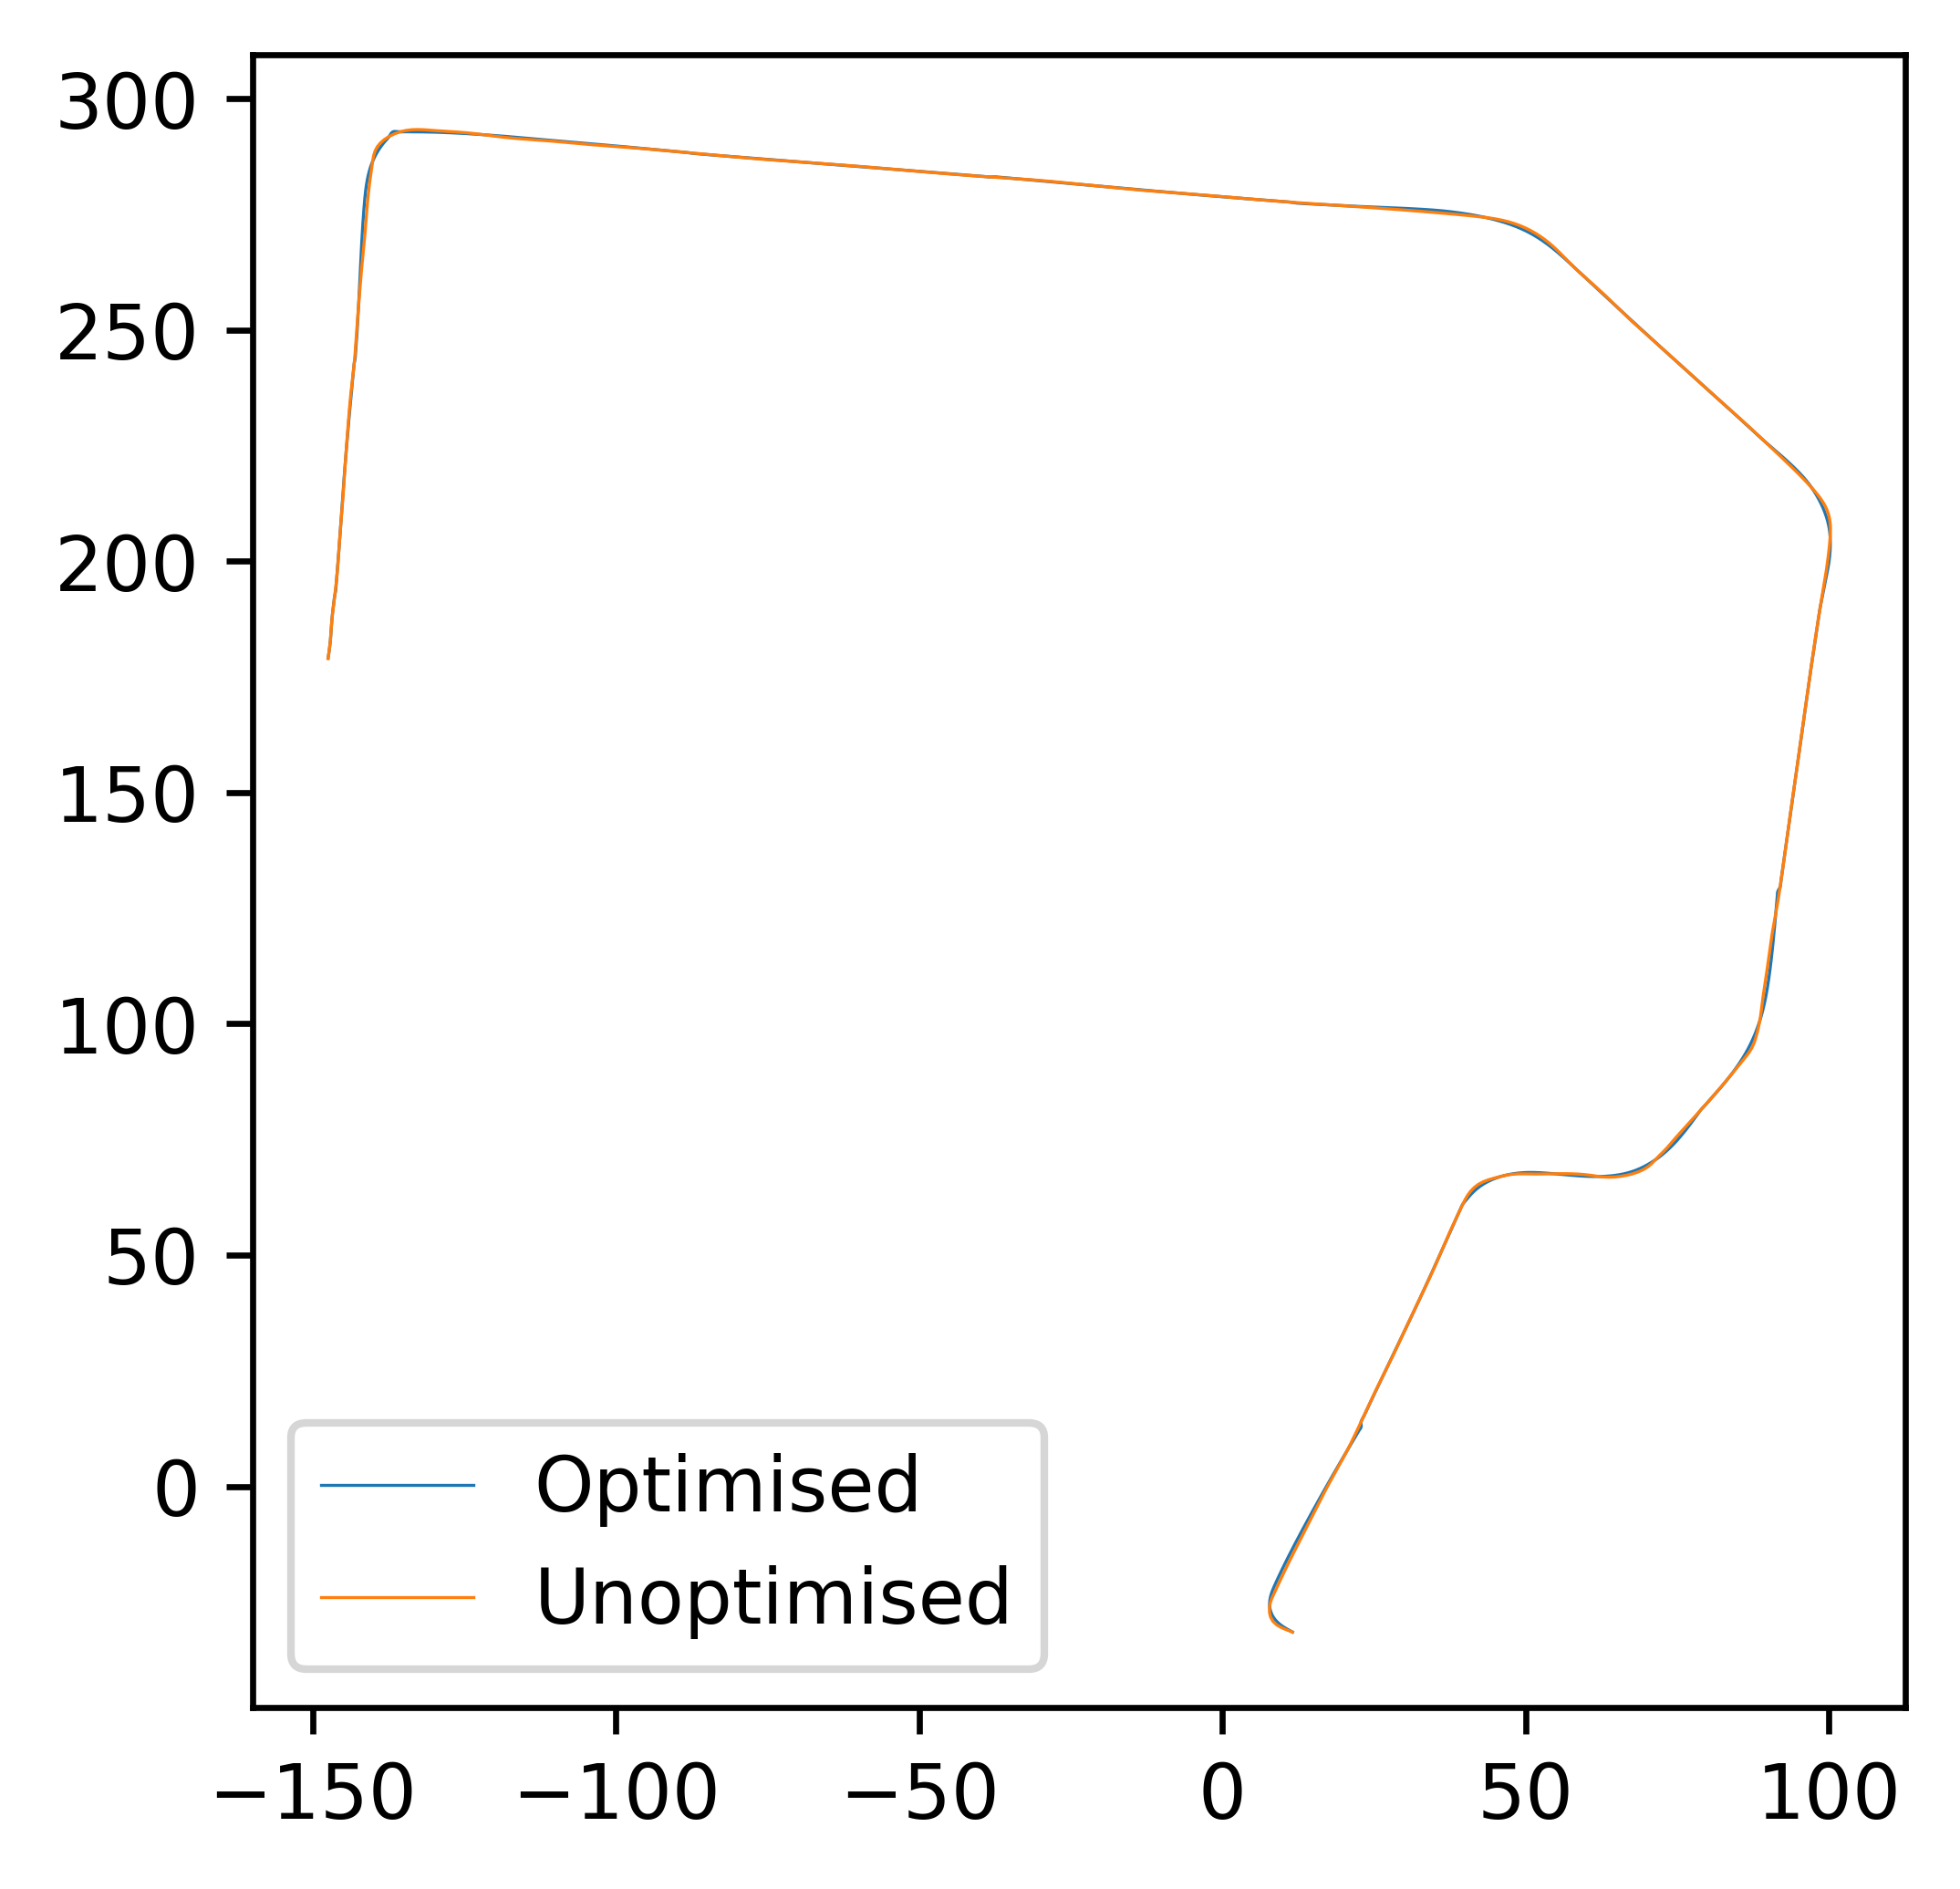

In [105]:
if result[iters].success:
    mox = px.copy()
    moy = py.copy() 
    combined_results = []

    for segments in range(0, iters):
        for point in range(0, len(pyaw_split[0])):
            combined_results.append(result[segments].x[point])

    for n in range(0, len(combined_results)):
        mox[n] -= combined_results[n]*np.sin(pyaw[n])
        moy[n] += combined_results[n]*np.cos(pyaw[n])

    ox, oy, _, ok = generate_cubic_path(mox, moy, 0.1)

    plt.figure(dpi=600)
    plt.axes().set_box_aspect(1)
    plt.plot(ox, oy, linewidth=0.4, label='Optimised')
    plt.plot(px, py, linewidth=0.4, label='Unoptimised')
    plt.legend()

In [100]:
if result[iters].success:
    mox = px.copy()
    moy = py.copy() 
    combined_results = []

    for segments in range(0, len(pyaw_split)):
        for point in range(0, len(pyaw_split[segments]))
            combined_results_x.append(px_split[segments][point])
            combined_results_y.append(py_split[segments][point])

    for n in range(0, len(pyaw)):
        mox[n] -= result.x[n]*np.sin(pyaw[n])
        moy[n] += result.x[n]*np.cos(pyaw[n])

    mok = calculate_curvature(mox, moy)
    dmok, _ = solve_1st_derivative(mok, mok)

    cum_mok = np.mean(np.absolute(mok))

    category = ['Optimised', 'Unoptimised']
    curvature = [cum_mok, cum_pk]

    gs = gridspec.GridSpec(3, 2)
    fig = plt.figure(dpi=175, figsize=(10, 6))

    ax1 = fig.add_subplot(gs[2, :]) 
    ax1.barh(category, curvature)
    ax1.set_xlabel('Cumulative Curvature (Smaller is better)')
    ax1.set_xlim((0, max(curvature) + (0.2*max(curvature))))

    for index, value in enumerate(curvature):
        ax1.text(value + (0.05*value), index, str(np.around(value, 5)))

    ax2 = fig.add_subplot(gs[0, 0], sharey=ax3)
    marker1, stem1, _, = ax2.stem(range(0, len(pk)), pk)
    ax2.set_ylabel('Discrete Curvature')
    ax2.set_xlabel('No. of Points')
    ax2.set_title('Unoptimised Path')

    ax3 = fig.add_subplot(gs[0, 1], sharey=ax2)
    marker2, stem2, _, = ax3.stem(range(0, len(mok)), mok)
    ax3.set_ylabel('Discrete Curvature')
    ax3.set_xlabel('No. of Points')
    ax3.set_title('Optimised Path')

    ax4 = fig.add_subplot(gs[1, 0])
    marker3, stem3, _, = ax4.stem(range(0, len(dpk)), dpk)
    ax4.set_ylabel('Discrete Curvature Rate')
    ax4.set_xlabel('No. of points')
    ax4.set_title('Unmodified Optimised Path')

    ax5 = fig.add_subplot(gs[1, 1], sharey=ax4)
    marker4, stem4, _, = ax5.stem(range(0, len(dmok)), dmok)
    ax5.set_ylabel('Discrete Curvature Rate')
    ax5.set_xlabel('No. of points')
    ax5.set_title('Modified Optimised Path')

    plt.setp(stem1, 'linewidth', 1)
    plt.setp(marker1, 'markersize', 2)
    plt.setp(stem2, 'linewidth', 1)
    plt.setp(marker2, 'markersize', 2)
    plt.setp(stem3, 'linewidth', 1)
    plt.setp(marker3, 'markersize', 2)
    plt.setp(stem4, 'linewidth', 1)
    plt.setp(marker4, 'markersize', 2)

    plt.tight_layout()
    plt.show()

else:
    raise Exception("Optimisation failed.")

SyntaxError: invalid syntax (<ipython-input-100-684f415121c0>, line 7)

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=600)

ax[0].set_box_aspect(1)
ax[0].set_title('Path')
ax[0].plot(lx, ly, '--b', alpha=0.5, linewidth=1, label='Lateral Constraint')
ax[0].plot(rx, ry, '--b', alpha=0.5, linewidth=1, label='Lateral Constraint')
ax[0].plot(road_lx, road_ly, '-k', linewidth=1)
ax[0].plot(road_rx, road_ry, '-k', linewidth=1)
ax[0].plot(mox, moy, color='magenta')

ax[1].set_box_aspect(1)
ax[1].set_title('Curvature')
ax[1].plot(mok, color='magenta')
ax[1].axhline(0, linestyle='--', color='k', alpha=0.2)

ax[2].set_box_aspect(1)
ax[2].set_title('Rate of Curvature')
ax[2].plot(dmok, color='magenta')
ax[2].axhline(0, linestyle='--', color='k', alpha=0.2)

plt.tight_layout()
plt.show()

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=600)

ax[0].set_box_aspect(1)
ax[0].set_title('Path')
ax[0].plot(lx, ly, '--b', alpha=0.5, linewidth=1, label='Lateral Constraint')
ax[0].plot(rx, ry, '--b', alpha=0.5, linewidth=1, label='Lateral Constraint')
ax[0].plot(road_lx, road_ly, '-k', linewidth=1)
ax[0].plot(road_rx, road_ry, '-k', linewidth=1)
ax[0].plot(px, py, color='gold', label='Seeding Path')
ax[0].plot(mox, moy, color='magenta', label='Optimised Path')
ax[0].legend()

ax[1].set_box_aspect(1)
ax[1].set_title('Curvature')
ax[1].plot(pk, color='gold', label='Seeding Path')
ax[1].plot(mok, color='magenta', label='Optimised Path')
ax[1].axhline(0, linestyle='--', color='k', alpha=0.2)
ax[1].legend()

ax[2].set_box_aspect(1)
ax[2].set_title('Rate of Curvature')
ax[2].plot(dpk, color='gold', label='Seeding Path')
ax[2].plot(dmok, color='magenta', label='Optimised Path')
ax[2].axhline(0, linestyle='--', color='k', alpha=0.2)
ax[2].legend()

plt.tight_layout()
plt.show()

### Remarks
The results from our modified approach has been promising. We were able to set a constraint value of 0.06 to maximum curvature and 0.01 to maximum rate of curvature.